### Zero Temperature Spin-Boson Model Dynamics using the Hierarchical Equations of Motion

We will now demonstrate how to use pyTTN to perform OQS dynamics for a spin-boson model using the non-unitary dynamics methods, namely the Hierarchical Equations of Motion (HEOM) and Quasi-Lindblad Pseudomode (pseudomode) methods.  In contrast to the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) and [TEDOPA](#dynamics-using-the-tedopa-method) examples, with these approaches we work with density matrices and pseudoboson modes that have in general complex frequency and couple to the system with non-hermitian system-bath coupling terms.    

The two approaches, HEOM and pseudomode, are up to a similarity transformation equivalent, and consequently the process for setting up the two approaches is incredibly similar.  Within pyTTN, this process is simplified through the use of the `pyttn.oqs.ExpFitBosonicBath` class, which similar to the `pyttn.oqs.DiscreteBosonicBath` provides a set of functions allowing or easy set up of non-unitary equation of motion based dynamics methods that make use of a sum-of-exponential decomposition for the bath correlation function. 

In this example, we demonstrate how to perform HEOM calculations for the spin-boson model considered above using pyTTN.  This example can be modified to perform pseudomode dynamics simply by replacing `method="heom"` with `method="pseudomode"`. 

##### Contents

1. [Import The Library](#importing-the-library)

2. [Setting up the Expfit Bosonic Bath](#setting-up-the-expfit-bosonic-bath)

3. [Setting up the System Information](#setting-up-the-system-information)

4. [Building the Generator](#building-the-generator)

5. [Building the ADOs Tensor Network](#building-the-ados-tensor-network)

6. [Preparing for Time Evolution](#preparing-for-time-evolution)

7. [Performing the Time Evolution](#performing-the-time-evolution)

##### Importing the Library

We start by importing the required modules:

In [4]:
import os
os.environ['OMP_NUM_THREADS']='1'

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

##### Setting up the Expfit Bosonic Bath

Next we define the spectral density of the bath and set up the `pyttn.oqs.BosonicBath` and `pyttn.oqs.ExpFitBosonicBath` objects.  In this example we have made use of the ESPRIT Fitting approach in order to construct a sum of exponential decomposition of the bath correlation function. 

In [5]:
#set the method for the pyttn.oqs.ExpFitBosonicBath object
method = "heom"

#number of modes in decomposition
K = 6

#set up the time evolution information
dt = 0.05
tmax = 15
nstep = int(tmax/dt)+1
t = np.arange(nstep+1)*dt

#set up the bath spectral density
alpha = 1.0
s = 1
wc = 5    

#setup the function for evaluating the exponential cutoff spectral density
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)

#set up the open quantum system bath object
bath = oqs.BosonicBath(J, beta=None)
dk, zk = bath.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))

expbath = oqs.ExpFitBosonicBath(dk, zk)

##### Setting up the System Information

Now we get the system information from the `pyttn.oqs.ExpFitBosonicBath` object, optionally applying mode combination to combine primitive bosonic modes into composite modes.  In constrast to the unitary Dynamics based approaches which make use of wavefunction descriptions, here we are working with a hierarchy of system density operators for representing the problem.  In order to construct the required density operator, we work with Liouville space vectors, and need to construct a system object consisting of two two-level-systems (to account for bra and ket variables states).

In [6]:
L = 30
Lmin = 4

expbath.truncate_modes(pyttn.utils.EnergyTruncation(10*wc, Lmax=L, Lmin=Lmin))

#setup the system information object
sysinf = pyttn.system_modes(1)
sysinf[0] = [pyttn.tls_mode(), pyttn.tls_mode()]

use_mode_combination = True
if use_mode_combination:
    nbmax=4
    nhilbmax=1000
    mode_comb = pyttn.utils.ModeCombination(nbmax, nhilbmax)
    bsys = expbath.system_information(mode_comb)
else:
    bsys = expbath.system_information()


#construct the system information object by combining the system information with the bath information
sysinf = pyttn.combine_systems(sysinf, bsys)

##### Building the Generator

We first start by constructing the system Liouvillian object, following which we add all terms acting on bath degrees of freedom.

In order to simplify construction of the HEOM Generator, the ExpFit bath object contains the `add_system_bath_generator` and `system_bath_generator` functions that, respectively, append to the system-bath Generator terms to an existing `SOP` object or return a new `sSOP` object containing all system-bath Hamiltonian terms.  

In [7]:
#set up parameters for the system
delta = 0.5
eps = 0

#set up the total Hamiltonian
H = pyttn.SOP(sysinf.nprimitive_modes())

#add on the system liouvillian - here we are using that sz^T = sz and "sx^T=sx"
H += (eps*pyttn.sOP("sz", 0) + delta*pyttn.sOP("sx", 0)) - (eps*pyttn.sOP("sz", 1)+delta*pyttn.sOP("sx", 1))
H = expbath.add_system_bath_generator(H, [pyttn.sOP("sz", 0), pyttn.sOP("sz", 1)], method=method)

Both the `add_system_bath_generator` and `system_bath_generator` functions can take a set of user defined indices corresponding to the bath modes (passed as the `binds` argument).  If this argument is not set, the function will assume that all bath modes are in a contiguous block starting at `bskip` which defaults to 1.  

Note: Care must be taken when defining the `binds` argument in conjunction with the use of mode_combination.  In the current release, pyTTN expects all composite modes to be formed of contiguous `primitive_modes`.


##### Building the ADOs Tensor Network

We are now in a position to prepare the ADO tensor tree topology.  Here, again, the `pyttn.oqs.ExpFitBosonicBath` class can help through the `add_bath_tree` function, which takes a node in an existing tree used to represent the system degrees of freedom and attaches either an MPS or balanced N-ary tree to represent the degrees of freedom handled by the discbath object.  

To build the tree, we first define the tree structure for system degrees of freedom, here noting that we have two two-level-system degrees of freedom for the system which has a dimension of 4, then attach the bath tree in the correct position.

In [8]:
#construct the topology and capacity trees used for constructing 
chi0 = 8
chi = 32
degree = 2

topo = pyttn.ntree("(1(4(4)))")
capacity = pyttn.ntree("(1(4(4)))")
linds = expbath.add_bath_tree(topo(), degree, chi0, chi0)
expbath.add_bath_tree(capacity(), degree, chi, chi)


[[0, 0, 0], [0, 1, 0], [1, 0]]

Note: For the case we are considering here this inserts the bath nodes in such a way that they agree with the ordering in the Generator.  In general, the ordering of modes in the tree structure is determined by their traversal order using a pre-order depth-first search traversal.  For more complex use cases, it may become necessary to set the `system_modes.mode_indices` variable of the `sysinf` object that specifies how composite mode indices in the Generator should be mapped to indices in the tree structure.

Now that we have constructed the tree topology, we can build the actually TTN ADO tensor.  Within the HEOM approach, the initial configuration corresponds to a direct product of an initial system density operator, $\hat{\rho}_S $, with a thermal bath state:

$$ \hat{\rho} = \hat{\rho}_S \bigotimes \frac{\mathrm{exp}(-\beta \hat{H}_B)}{\mathrm{Tr}_B\left(\mathrm{exp}(-\beta \hat{H}_B)\right)} $$

This corresponds to an ADO tensor, in which the auxiliary boson modes are in the vacuum state, and the system vector is obtained by flattening the initial density operator matrix.  Here we consider a state where the system is initially in the $\ket{0}\bra{0}$ state.  As such, creation of the initial ADOs tensor is straightfoward

In [9]:

A = pyttn.ttn(topo, capacity, dtype=np.complex128)
state = [0] + [0 for i in range(len(bsys))]
A.set_state(state)


##### Preparing for Time Evolution

Now the final steps before preparing for the time-evolution are to:

1. construct the `sop_operator` representation.  Here we will use the hierarchical SOP representation of the Generator as it leads to considerable performance improvements compared to the SOP representation.
2. setup any observables of interest for the system.  Here, we will look at the magnetisation of the spin throughout the dynamics process, and so will set up a site_operator object to allow for evaluation of this quantity.
3. setup the `matrix_element` object used to evaluate expectation values.
5. create the `tdvp` object for time evolution.  Here we will use the adaptive one-site algorithm for time-evolution.

Within the HEOM approach, the evaluation of expectation values is changed significantly from the unitary dynamics case.  In particular, given an ADO state, the expectation value of a system operator can be obtained as

$$ \left\langle \hat{A} \right\rangle = \mathrm{Tr}\left[\hat{A}^\dagger \hat{\rho}_S\right] $$

In order to simplify the evaluation of this quantity, we define an additional TTN `trace_ttn` that has bond-dimension $1$ everywhere and is given as the direct product of the identity operator acting on the system degrees of freedom and the vacuum state of the auxiliary boson modes.

In [10]:
h = pyttn.sop_operator(H, A, sysinf)


#set up ttns storing the observable to be measured.  Here these are just system observables
#so we form a tree with the same topology as A but with all bath bond dimensions set to 1
obstree = pyttn.ntree("(1(4(4)))")
expbath.add_bath_tree(obstree(), degree, 1, 1)
trace_ttn = pyttn.ttn(obstree, dtype=np.complex128)
trace_ttn.set_product([np.identity(2).flatten()] + expbath.identity_product_state(method=method))

szop = pyttn.site_operator(pyttn.sOP("sz", 0), sysinf)
mel = pyttn.matrix_element(A)

#set up buffers to store the observable
Sz = np.zeros(nstep+1)

#set up the tdvp object
sweep = pyttn.tdvp(A, h, krylov_dim = 12, expansion='subspace', subspace_neigs = 4, subspace_krylov_dim = 8)
sweep.spawning_threshold = 1e-10
sweep.minimum_unoccupied=0

sweep.dt = dt
sweep.coefficient = -1.0j

##### Performing the Time Evolution

Now that everything is set up we are in a position where we can perform each of the time-evolution steps and measure the observables of interest. 

 Here we make use of a little trick for improving the accuracy of the time-evolution at short time. For systems initially in the product state, the ttn wavefunction represents a rather constrained manifold, and the dynamics can depend strongly on the choice of initially unoccupied basis functions.  To alleviate this, it can be useful to perform small steps initially in order to allow for these unoccupied functions to evolve partially under the Hamiltonian of the system before too much damage has been done to the wavefunction.  As shown in Ref., this can dramatically improve the accuracy of the TDVP calculations with only very modest additional computational cost.

In [11]:
Sz[0] = np.real(mel(szop, A, trace_ttn))

#perform the first timestep using a logarithmic discretisation of time over this period.  
#This can be useful to allow for suitable adaptation of weakly occupied single particle 
#functions through the initial time point.
tp = 0
ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), 5)
for i in range(5):
    dti = ts[i]-tp
    sweep.dt = dti
    sweep.step(A, h)
    tp = ts[i]

i=1
#set the values after the first timestep
Sz[i] =np.real(mel(szop, A, trace_ttn))
sweep.dt = dt

#now perform standard time stepping
for i in range(1,nstep):
    sweep.step(A, h)
    Sz[i+1] = np.real(mel(szop, A, trace_ttn))
    print("step: %d of %d.  Chimax: %d"%(i+1, nstep, A.maximum_bond_dimension()), end='                   \r')
print('                                                       \r')

And now that we have finished the time evolution we can plot the resultant magnetisation.

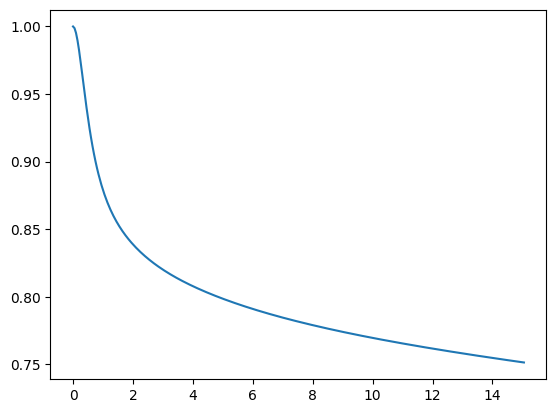

In [12]:
plt.plot(t, Sz)
plt.show()

And we can also do things like visualise how the bond dimension has expanded throughout the tensor network.

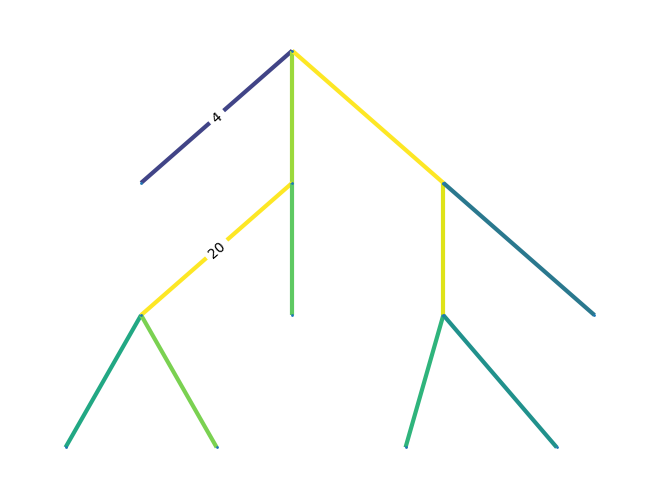

In [13]:
visualise_tree(A, node_size=1, bond_prop="bond dimension")
plt.show()

In [14]:
print(sysinf.mode_dimensions())
print(np.prod(np.array(sysinf.mode_dimensions())))

[4, 900, 900, 256, 36, 16, 16]
7644119040000
